In [1]:
# Import packages
import os

import torch.multiprocessing as mp
import torch.optim as optim
import torch.utils.data
import torchvision.transforms.v2 as tvt
from matplotlib import pyplot as plt

from my_modules.custom_models import *
from my_modules.model_learning.model_metrics import score_model
from my_modules.nsclc import patient_wise_train_test_splitter
from my_modules.nsclc.nsclc_dataset import NSCLCDataset

In [9]:
# Prepare data
data = NSCLCDataset('E:/NSCLC_Data_for_ML',
                    ['orr', 'g', 's', 'photons', 'tau1', 'tau2', 'alpha1', 'alpha2', 'taumean', 'boundfraction'],
                    device='cpu', label='Metastases', mask_on=False)
data.normalize_channels('preset')
data.transforms = tvt.Compose([tvt.RandomVerticalFlip(p=0.25),
                               tvt.RandomHorizontalFlip(p=0.25),
                               tvt.RandomRotation(degrees=(-180, 180))])
data.augment()

In [10]:
model = RegularizedParallelCNNet(data.shape)
model.load_state_dict(torch.load(r'C:\Users\jdivers\Downloads\nsclc_Metastases_orr+g+s+photons+tau1+tau2+alpha1+alpha2+taumean+boundfraction_Augmented__Regularized Parallel CN Net__1e-06_499.pth', map_location=torch.device('cpu')))

C:\Users\jdivers\PycharmProjects\NSCLC_Classification\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Cache opened.


<All keys matched successfully>

Variance in filter weights at input

In [45]:
input_var, label = zip(*[(torch.var(model.state_dict()[f'conv1.{ch}.weight']).item(), label) for ch, label in enumerate(data.mode)]) 

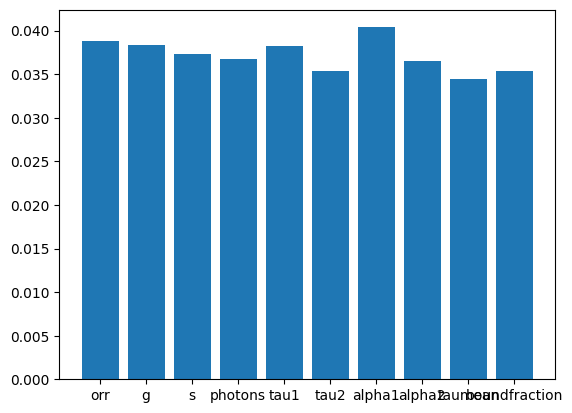

In [62]:
fig, ax = plt.subplots()
ax.bar(label, input_var)
plt.show()

Weights magnitude after single-channel processes 

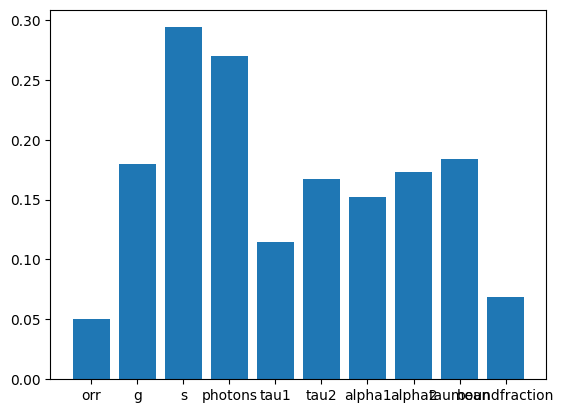

In [70]:
fig, ax = plt.subplots()
ax.bar(data.mode, torch.abs(torch.squeeze(model.state_dict()['fc3.weight'])))
plt.show()

In [ ]:
merge_var, label = zip(*[(torch.var(model.state_dict()[f'fc3.weight']).item(), label) for ch, label in enumerate(data.mode)]) 
fig, ax = plt.subplots()
ax.bar(label, input_var)
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.bar(label, input_var)
plt.show()

Visualization of input filters

In [78]:
model.state_dict()['fc2.0.weight'].shape

torch.Size([1, 128])

In [79]:
import torchvision

for name, filters in model.named_parameters():
    if (('conv1' in name or 'conv2' in name) and 'weight' in name):
        try:
            n,c,h,w = filters.shape
            filters = filters[:, 0, :, :].unsqueeze(1) if c != 3 else filters
            
            rows = np.min((filters.shape[0] // 9, 64))
            grid = torchvision.utils.make_grid(filters, nrow=9, normalize=True, padding=1)
            plt.figure(figsize = (9,9))
            plt.imshow(grid.numpy().transpose(1, 2, 0))
            plt.axis('off')
            plt.ioff()
            plt.savefig(f'{name}_filters.png')
            plt.close()
        except Exception as e:
            pass

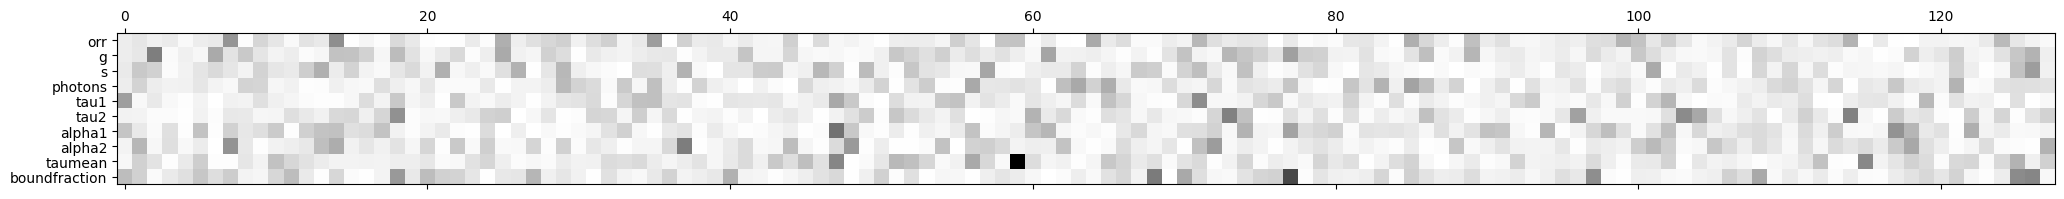

In [140]:
merge_weight_arr = torch.cat([model.state_dict()[f'fc2.{ch}.weight'] for ch in range(data.stack_height)])
fig, ax = plt.subplots(figsize = (25, 10))
ax.matshow(torch.log(torch.abs(merge_weight_arr)))
ax.set_yticks(range(data.stack_height), data.mode) 
plt.set_cmap('gray')
plt.show()

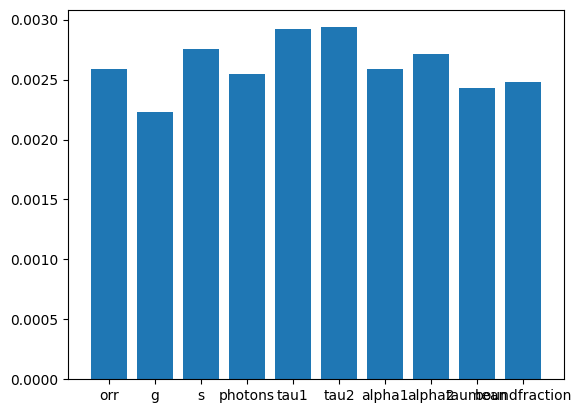

In [146]:
merge_weight_var = torch.var(merge_weight_arr, dim=1)
fig, ax = plt.subplots()
ax.bar(data.mode, merge_weight_var)
plt.show()

In [148]:
y = []
for x, target in data:
    y.append(model(x.unsqueeze(0)).item())

C:\Users\jdivers\PycharmProjects\NSCLC_Classification\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [150]:
targets = [data[i][1] for i in range(len(data))]

In [156]:
for th in sorted(y[:]):
    pred = torch.zeros_like(torch.tensor(y))
    pred[torch.tensor(y) >= th] = 1
    print(f'{th}: {torch.sum(pred == torch.tensor(targets)) / len(targets)}')

-3.224222183227539: 0.5639097690582275
-3.178307294845581: 0.5654135346412659
-2.9547278881073: 0.5669173002243042
-2.888059139251709: 0.5684210658073425
-2.8217616081237793: 0.5699248313903809
-2.6915769577026367: 0.5714285969734192
-2.49360990524292: 0.5729323029518127
-2.486476421356201: 0.5744360685348511
-2.4684081077575684: 0.5759398341178894
-2.3863954544067383: 0.5744360685348511
-2.321573257446289: 0.5759398341178894
-2.319641590118408: 0.5774435997009277
-2.228182315826416: 0.5759398341178894
-2.1813535690307617: 0.5774435997009277
-2.1580007076263428: 0.5789473652839661
-2.148602247238159: 0.5804511308670044
-2.1442723274230957: 0.5819548964500427
-2.141667127609253: 0.5804511308670044
-2.1391217708587646: 0.5819548964500427
-2.1323118209838867: 0.5804511308670044
-2.127805233001709: 0.5819548964500427
-2.1253108978271484: 0.583458662033081
-2.1034953594207764: 0.5849624276161194
-2.019627571105957: 0.5864661931991577
-2.0128347873687744: 0.5849624276161194
-1.95707035064697

# Repeat for next model

In [165]:
model = RegularizedParallelCNNet(data.shape)
model.load_state_dict(torch.load(r'C:\Users\jdivers\Downloads\nsclc_Metastases_orr+g+s+photons+tau1+tau2+alpha1+alpha2+taumean+boundfraction_Augmented__Regularized Parallel CN Net__1e-06_124.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

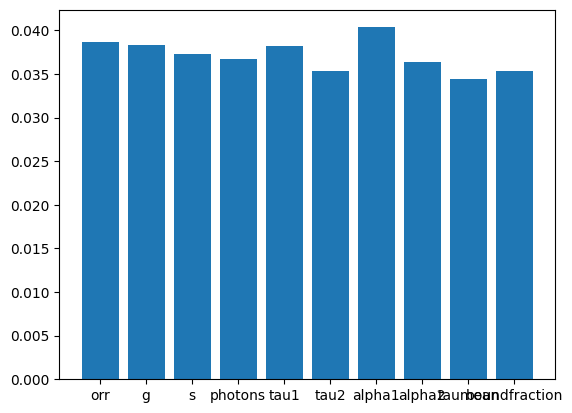

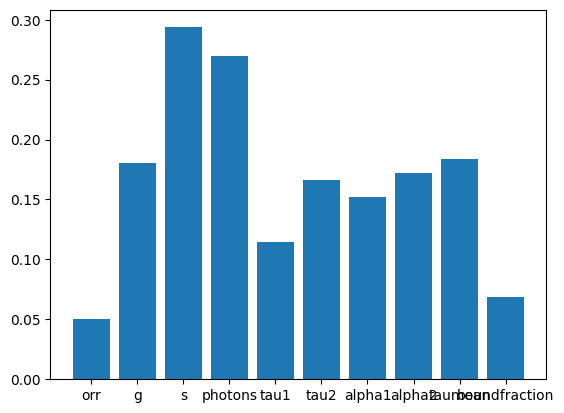

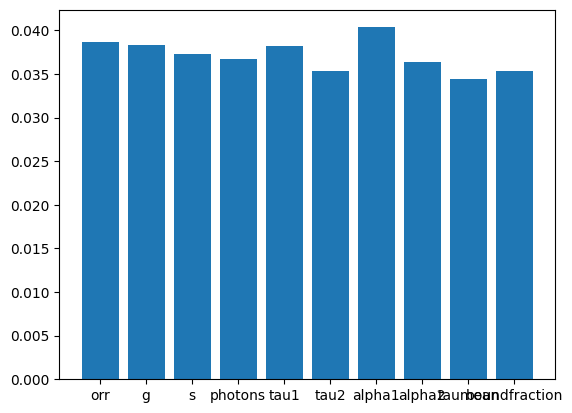

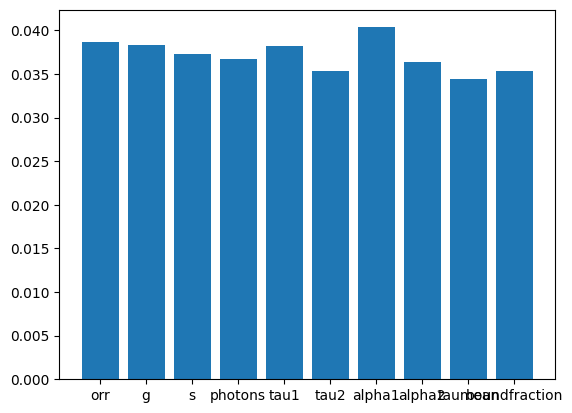

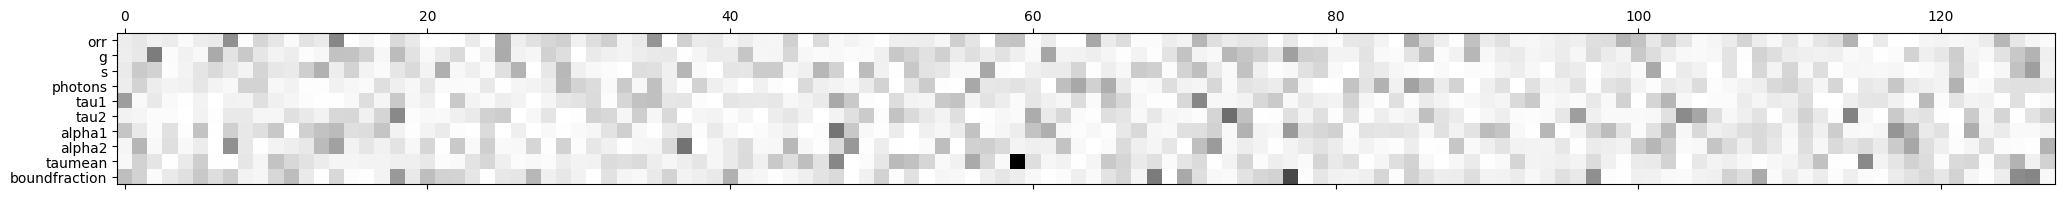

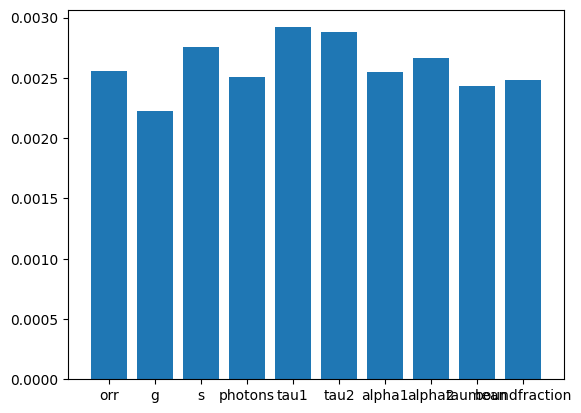

In [166]:
input_var, label = zip(*[(torch.var(model.state_dict()[f'conv1.{ch}.weight']).item(), label) for ch, label in enumerate(data.mode)]) 

fig, ax = plt.subplots()
ax.bar(label, input_var)
plt.show()

fig, ax = plt.subplots()
ax.bar(data.mode, torch.abs(torch.squeeze(model.state_dict()['fc3.weight'])))
plt.show()
merge_var, label = zip(*[(torch.var(model.state_dict()[f'fc3.weight']).item(), label) for ch, label in enumerate(data.mode)]) 

fig, ax = plt.subplots()
ax.bar(label, input_var)
plt.show()

fig, ax = plt.subplots()
ax.bar(label, input_var)
plt.show()
model.state_dict()['fc2.0.weight'].shape

import torchvision

for name, filters in model.named_parameters():
    if (('conv1' in name or 'conv2' in name) and 'weight' in name):
        try:
            n,c,h,w = filters.shape
            filters = filters[:, 0, :, :].unsqueeze(1) if c != 3 else filters
            
            rows = np.min((filters.shape[0] // 9, 64))
            grid = torchvision.utils.make_grid(filters, nrow=9, normalize=True, padding=1)
            plt.figure(figsize = (9,9))
            plt.imshow(grid.numpy().transpose(1, 2, 0))
            plt.axis('off')
            plt.ioff()
            plt.savefig(f'{name}_filters.png')
            plt.close()
        except Exception as e:
            pass
        
merge_weight_arr = torch.cat([model.state_dict()[f'fc2.{ch}.weight'] for ch in range(data.stack_height)])
fig, ax = plt.subplots(figsize = (25, 10))
ax.matshow(torch.log(torch.abs(merge_weight_arr)))
ax.set_yticks(range(data.stack_height), data.mode) 
plt.set_cmap('gray')
plt.show()

merge_weight_var = torch.var(merge_weight_arr, dim=1)
fig, ax = plt.subplots()
ax.bar(data.mode, merge_weight_var)
plt.show()